### Import Library

In [1]:
import os
import pickle
import torch
import torch.nn as nn
from typing import List, Optional, cast
import numpy as np
from PIL import Image
from glob import glob
from copy import deepcopy
import json
import csv
from tabulate import tabulate
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from transformers import AutoImageProcessor, Dinov2WithRegistersConfig
from transformers.modeling_outputs import ImageClassifierOutput
from transformers.trainer import Trainer
from transformers.training_args import TrainingArguments
from torch.utils.data import Dataset
from transformers.data.data_collator import default_data_collator
from sklearn.metrics import accuracy_score, f1_score
from sklearn.preprocessing import LabelEncoder
from transformers.trainer_callback import EarlyStoppingCallback, TrainerCallback
from torchvision import transforms
from config import BASE_MODEL_NAME, NUM_CLASSES , HIDDEN_DIM, DATASET_DIR
from model import CustomDinoV2ClassifierWithReg

### Train Config and Load Model

In [ ]:
# Train Config
BATCH_SIZE  = 32
NUM_EPOCHS  = 50

# Load pretrained DINOv2 backbone + processor
processor = AutoImageProcessor.from_pretrained(BASE_MODEL_NAME, cache_dir="./cache", use_fast=True)
config = cast(Dinov2WithRegistersConfig, Dinov2WithRegistersConfig.from_pretrained(BASE_MODEL_NAME, cache_dir="./cache"))

model = CustomDinoV2ClassifierWithReg.from_pretrained(
    BASE_MODEL_NAME,
    config=config,
    num_classes=NUM_CLASSES,
    hidden_dim=HIDDEN_DIM,
    cache_dir="./cache"
)

# Optionally Freeze backbone
'''
model.backbone.requires_grad_(False)
for param in model.backbone.parameters():
    param.requires_grad = False
'''

Some weights of CustomDinoV2ClassifierWithReg were not initialized from the model checkpoint at facebook/dinov2-with-registers-base and are newly initialized: ['backbone.embeddings.cls_token', 'backbone.embeddings.mask_token', 'backbone.embeddings.patch_embeddings.projection.bias', 'backbone.embeddings.patch_embeddings.projection.weight', 'backbone.embeddings.position_embeddings', 'backbone.embeddings.register_tokens', 'backbone.encoder.layer.0.attention.attention.key.bias', 'backbone.encoder.layer.0.attention.attention.key.weight', 'backbone.encoder.layer.0.attention.attention.query.bias', 'backbone.encoder.layer.0.attention.attention.query.weight', 'backbone.encoder.layer.0.attention.attention.value.bias', 'backbone.encoder.layer.0.attention.attention.value.weight', 'backbone.encoder.layer.0.attention.output.dense.bias', 'backbone.encoder.layer.0.attention.output.dense.weight', 'backbone.encoder.layer.0.layer_scale1.lambda1', 'backbone.encoder.layer.0.layer_scale2.lambda1', 'backbone

## Load Datasets

In [2]:
# Load image from DATASET DIR
image_paths = []
labels = []
for class_folder in os.listdir(DATASET_DIR):
    class_path = os.path.join(DATASET_DIR, class_folder)
    if os.path.isdir(class_path):
        # Assume images are jpg/png inside
        for img_file in glob(os.path.join(class_path, "*.*")):
            image_paths.append(img_file)
            labels.append(class_folder)

print(f"Total images: {len(image_paths)}, classes: {len(set(labels))}")

Total images: 1682, classes: 131


### Label encoding

In [3]:
# Encode labels as integers
label_encoder_path = "./pickle/label_encoder.pkl"

if os.path.exists(label_encoder_path):
    with open(label_encoder_path, "rb") as f:
        le = pickle.load(f)
    print("LabelEncoder loaded from file.")
else:
    le = LabelEncoder()
    with open(label_encoder_path, "wb") as f:
        pickle.dump(le, f)
    print("LabelEncoder created and saved to file.")

labels_encoded = le.fit_transform(labels)
for original_label, encoded_label in zip(le.classes_, range(len(le.classes_))):
    print(f"{original_label} -> {encoded_label}")

with open("label_mapping.csv", "w", newline='') as f:
    writer = csv.writer(f)
    writer.writerow(["original_label", "encoded_label"])
    for original_label, encoded_label in zip(le.classes_, range(len(le.classes_))):
        writer.writerow([original_label, encoded_label])

print("Saved label mapping to label_mapping.csv")

LabelEncoder loaded from file.
Acridotheres javanicus -> 0
Acridotheres melanopterus -> 1
Acridotheres tristis -> 2
Aethopyga siparaja -> 3
Alcedo atthis -> 4
Alcippe pyrrhoptera -> 5
Anas gibberifrons -> 6
Anastomus oscitans -> 7
Apalharpactes mackloti -> 8
Apalharpactes reinwardtii -> 9
Apus pacificus -> 10
Arses telescophthalmus -> 11
Artamus monachus -> 12
Batrachostomus affinis -> 13
Buceros rhinoceros -> 14
Cacatua moluccensis -> 15
Cacatua sulphurea -> 16
Caloenas nicobarica -> 17
Calyptomena hosei -> 18
Calyptomena viridis -> 19
Carpococcyx radiceus -> 20
Carpococcyx sumatranus -> 21
Carterornis chrysomela -> 22
Casuarius casuarius -> 23
Ceryle rudis -> 24
Ceyx fallax -> 25
Chalcophaps indica -> 26
Charadrius javanicus -> 27
Charmosyna papou -> 28
Chloropsis venusta -> 29
Cicinnurus regius -> 30
Ciconia episcopus -> 31
Cinnyris jugularis -> 32
Cissa thalassina -> 33
Collocalia esculenta -> 34
Copsychus saularis -> 35
Corvus fuscicapillus -> 36
Corvus typicus -> 37
Cyornis monta

### Split training and test

In [ ]:
split_file = "./pickle/split_indices.pkl"
if os.path.exists(split_file):
    print(f"Loading train/val split from {split_file}")
    with open(split_file, "rb") as f:
        indices = pickle.load(f)
        train_idx = indices["train"]
        val_idx = indices["val"]
else:
    print(f"Generating new train/val split and saving to {split_file}")
    train_idx, val_idx = train_test_split(
        range(len(image_paths)), test_size=0.2, stratify=labels_encoded, random_state=42
    )
    with open(split_file, "wb") as f:
        pickle.dump({"train": train_idx, "val": val_idx}, f)

Loading train/val split from split_indices.pkl


### Custom Dataset Class

In [6]:
# Custom Dataset class for HuggingFace Trainer
class BirdDataset(Dataset):
    def __init__(self, image_paths: List[str], labels: List[int], processor: AutoImageProcessor, augment = False):
        self.image_paths = image_paths
        self.labels = labels
        self.processor = processor
        self.augment = augment
        self.augmentations = transforms.Compose([
            transforms.RandomResizedCrop(224, scale=(0.8, 1.0)),
            transforms.RandomHorizontalFlip(),
            transforms.ColorJitter(0.1, 0.1, 0.1, 0.05),
        ])


    def __len__(self) -> int:
        """Returns the total number of images in the dataset."""
        return len(self.image_paths)

    def __getitem__(self, idx: int) -> dict:
        # Load the image (using PIL)
        image = Image.open(self.image_paths[idx]).convert("RGB")
        
        # Retrieve the label (already encoded as an integer)
        label = self.labels[idx]

        if self.augment:
            image = self.augmentations(image)
        
        # Use processor to prepare the image for the model
        encoding = self.processor(images=image, return_tensors="pt") # type: ignore
        
        # Return the processed image (pixel_values) and the label
        return {"pixel_values": encoding["pixel_values"].squeeze(0), "label": torch.tensor(label)}

In [7]:
# Split data into training and validation sets using the indices
train_image_paths = [image_paths[i] for i in train_idx]
train_labels = [labels_encoded[i] for i in train_idx] # type: ignore

val_image_paths = [image_paths[i] for i in val_idx]
val_labels = [labels_encoded[i] for i in val_idx] # type: ignore

# Create dataset objects for train and validation
train_dataset = BirdDataset(train_image_paths, train_labels, processor, augment=True) # type: ignore
val_dataset = BirdDataset(val_image_paths, val_labels, processor) # type: ignore

# Use default data collator to handle batching
data_collator = default_data_collator

### Training

In [8]:
def compute_metrics(eval_pred):
    logits, labels = eval_pred.predictions, eval_pred.label_ids
    preds = np.argmax(logits, axis=-1)
    return {
        "accuracy": accuracy_score(labels, preds),
        "f1": f1_score(labels, preds, average="weighted"),
    }

In [12]:
from tqdm.auto import tqdm

early_stopping_callback = EarlyStoppingCallback(
    early_stopping_patience=5,  # Stop after 5 epochs without improvement
    early_stopping_threshold=0.0001,  # Minimum improvement to reset the patience counter
)

# Will print training metrics if used in regular py file (not ipynb)
# Also saved to results/{directory}/checkpoint-{number}/trainer_state.json
class TrainingDataInfoCallback(TrainerCallback):
    def __init__(self, trainer) -> None:
        super().__init__()
        self._trainer = trainer
        self._header_printed = False
    
    def on_epoch_end(self, args, state, control, **kwargs): # type: ignore
        if control.should_evaluate:
            control_copy = deepcopy(control)
            metrics = self._trainer.evaluate(eval_dataset=self._trainer.train_dataset, metric_key_prefix="train")
            train_loss = metrics.get("train_loss", float("nan"))
            train_acc = metrics.get("train_accuracy", float("nan"))
            train_f1 = metrics.get("train_f1", float("nan"))

            if not self._header_printed:
                print(f"{'Epoch':<8}{'Train Loss':<15}{'Train Accuracy':<15}{'F1':<10}")
                self._header_printed = True

            print(f"{state.epoch:<8.0f}{train_loss:<15.6f}{train_acc:<15.6f}{train_f1:<10.6f}")
            return control_copy

In [ ]:
from datetime import datetime
current_time = datetime.now().strftime("%Y-%m-%d_%H-%M-%S")

# Directories with timestamp
output_dir = f"./results/{current_time}"
logging_dir = f"./logs/{current_time}"

# Set up TrainingArguments
# Change to "steps" strategy for non aggressive model saving
training_args = TrainingArguments(
    output_dir=output_dir,          # output directory where the model checkpoints will be saved
    eval_strategy="epoch",          # Evaluate after each epoch
    save_strategy="epoch",
    learning_rate=4e-5,                      # Learning rate for Adam optimizer . use 1e-5 if batch size = 16
    per_device_train_batch_size=BATCH_SIZE,  # Batch size for training
    per_device_eval_batch_size=BATCH_SIZE,   # Batch size for evaluation
    num_train_epochs=NUM_EPOCHS,            # Number of training epochs
    weight_decay=0.01,                      # Weight decay for optimization
    logging_dir=logging_dir,                # Directory for logs
    logging_strategy="epoch",               # log after every epoch
    save_steps=2000,                        # Save checkpoint every 500 steps
    save_total_limit= 5,
    load_best_model_at_end=True,            # Load the best model when training finishes
    metric_for_best_model="accuracy",       # Metric to use for best model selection
    lr_scheduler_type = "cosine",
    warmup_ratio= 0.04,
    max_grad_norm=1.0, 
    disable_tqdm=False, # Enable to improve performance by a lot
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
    callbacks=[early_stopping_callback],
)
trainer.add_callback(TrainingDataInfoCallback(trainer)) 

print(output_dir)
print(logging_dir)

./results/2025-06-05_23-44-08
./logs/2025-06-05_23-44-08


In [ ]:
if __name__ == "__main__":
    try:
        os.environ["TRANSFORMERS_NO_TF"] = "1"
        trainer.train()
        model.save_pretrained(output_dir)
        processor.save_pretrained(output_dir)
    except (KeyboardInterrupt, InterruptedError):
        pass
    except Exception as e:
        print(f"{e}")

Epoch,Training Loss,Validation Loss


## Visualize

In [26]:
# Load the JSON data from your file
with open(r"backup\results\checkpoint-817\trainer_state.json", "r") as f:
    data = json.load(f)

### Graph

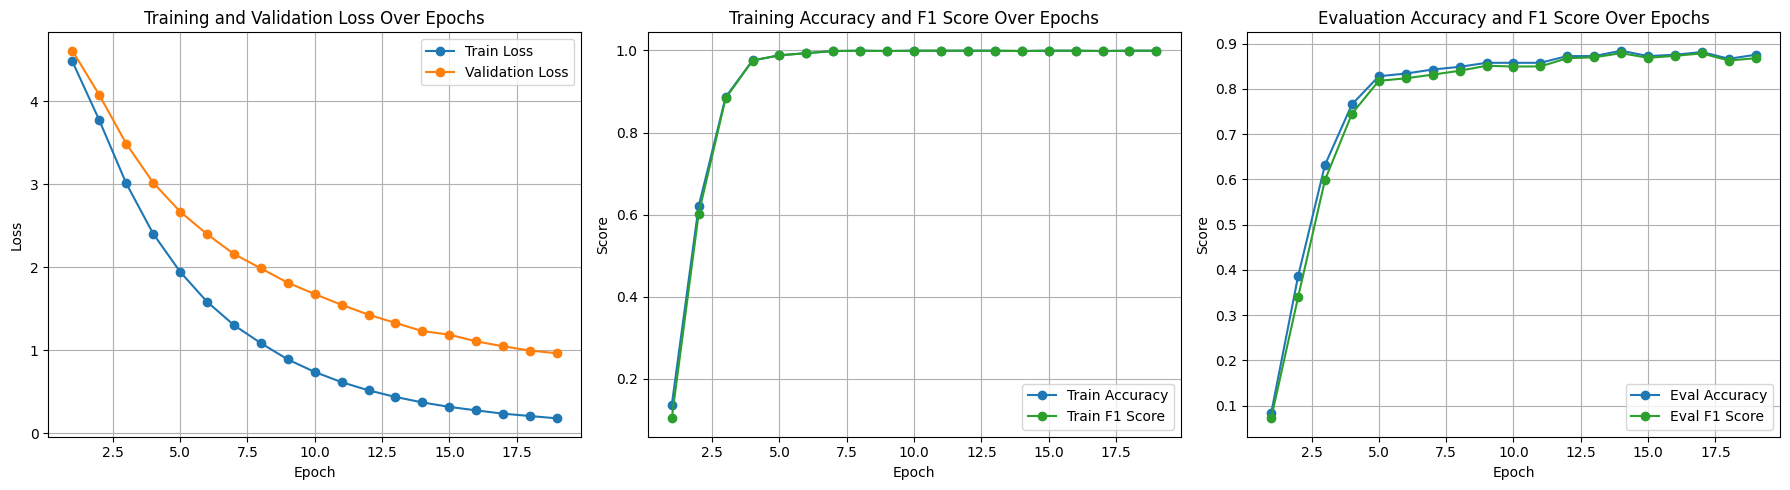

In [27]:
# Initialize lists to hold the metrics for plotting
epochs = []
train_accuracies = []
train_f1_scores = []
train_losses = []
eval_accuracies = []
eval_f1_scores = []
eval_losses = []

# Extract values from the log history
for entry in data["log_history"]:
    if "epoch" in entry:
        if "train_accuracy" in entry and "train_f1" in entry and "train_loss" in entry:
            epochs.append(entry["epoch"])
            train_accuracies.append(entry["train_accuracy"])
            train_f1_scores.append(entry["train_f1"])
            train_losses.append(entry["train_loss"])
        elif "eval_accuracy" in entry and "eval_f1" in entry and "eval_loss" in entry:
            eval_accuracies.append(entry["eval_accuracy"])
            eval_f1_scores.append(entry["eval_f1"])
            eval_losses.append(entry["eval_loss"])

# Create figure with 3 subplots
plt.figure(figsize=(18, 5))

# Graph 1: Train and Validation Loss
plt.subplot(1, 3, 1)
plt.plot(epochs, train_losses, label='Train Loss', color='tab:blue', marker='o')
plt.plot(epochs, eval_losses, label='Validation Loss', color='tab:orange', marker='o')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.legend()
plt.grid(True)

# Graph 2: Training Accuracy and F1 Score
plt.subplot(1, 3, 2)
plt.plot(epochs, train_accuracies, label='Train Accuracy', color='tab:blue', marker='o')
plt.plot(epochs, train_f1_scores, label='Train F1 Score', color='tab:green', marker='o')
plt.xlabel('Epoch')
plt.ylabel('Score')
plt.title('Training Accuracy and F1 Score Over Epochs')
plt.legend()
plt.grid(True)

# Graph 3: Evaluation Accuracy and F1 Score
plt.subplot(1, 3, 3)
plt.plot(epochs, eval_accuracies, label='Eval Accuracy', color='tab:blue', marker='o')
plt.plot(epochs, eval_f1_scores, label='Eval F1 Score', color='tab:green', marker='o')
plt.xlabel('Epoch')
plt.ylabel('Score')
plt.title('Evaluation Accuracy and F1 Score Over Epochs')
plt.legend()
plt.grid(True)

# Adjust layout and display
plt.tight_layout()
plt.show()

### Training Metrics

In [32]:
# Extract and format training metrics
train_metrics = []
for entry in data["log_history"]:
    if "train_accuracy" in entry:
        train_metrics.append([
            f"{int(entry['epoch'])}",
            f"{entry['train_accuracy']*100:.2f}%",
            f"{entry['train_f1']:.4f}",
            f"{entry['train_loss']:.4f}"
        ])

# Print professional training table
print("\nTRAINING METRICS")
print(tabulate(train_metrics, 
              headers=["Epoch", "Accuracy", "F1 Score", "Loss"],
              tablefmt="fancy_grid",
              numalign="center",
              stralign="center",
              colalign=("center", "center", "center", "center")))


TRAINING METRICS
╒═════════╤════════════╤════════════╤════════╕
│  Epoch  │  Accuracy  │  F1 Score  │  Loss  │
╞═════════╪════════════╪════════════╪════════╡
│    1    │   13.61%   │   0.104    │ 4.4835 │
├─────────┼────────────┼────────────┼────────┤
│    2    │   62.08%   │   0.6027   │ 3.7732 │
├─────────┼────────────┼────────────┼────────┤
│    3    │   88.62%   │   0.8834   │ 3.012  │
├─────────┼────────────┼────────────┼────────┤
│    4    │   97.55%   │   0.9754   │ 2.405  │
├─────────┼────────────┼────────────┼────────┤
│    5    │   98.81%   │   0.988    │ 1.9459 │
├─────────┼────────────┼────────────┼────────┤
│    6    │   99.33%   │   0.9932   │ 1.5838 │
├─────────┼────────────┼────────────┼────────┤
│    7    │   99.85%   │   0.9985   │ 1.3022 │
├─────────┼────────────┼────────────┼────────┤
│    8    │   99.93%   │   0.9993   │ 1.0844 │
├─────────┼────────────┼────────────┼────────┤
│    9    │   99.85%   │   0.9985   │ 0.8878 │
├─────────┼────────────┼────────────┼─────

### Evaluation Metrics

In [ ]:
# Extract and format evaluation metrics
eval_metrics = []
for entry in data["log_history"]:
    if "eval_accuracy" in entry:
        eval_metrics.append([
            f"{int(entry['epoch'])}",
            f"{entry['eval_accuracy']*100:.2f}%",
            f"{entry['eval_f1']:.4f}",
            f"{entry['eval_loss']:.4f}"
        ])

# Print professional evaluation table
print("\nEVALUATION METRICS")
print(tabulate(eval_metrics, 
              headers=["Epoch", "Accuracy", "F1 Score", "Loss"],
              tablefmt="fancy_grid",
              numalign="center",
              stralign="center",
              colalign=("center", "center", "center", "center")))


EVALUATION METRICS
╒═════════╤════════════╤════════════╤════════╕
│  Epoch  │  Accuracy  │  F1 Score  │  Loss  │
╞═════════╪════════════╪════════════╪════════╡
│    1    │   8.31%    │   0.0722   │ 4.6126 │
├─────────┼────────────┼────────────┼────────┤
│    2    │   38.58%   │   0.3395   │ 4.0784 │
├─────────┼────────────┼────────────┼────────┤
│    3    │   63.20%   │   0.5986   │ 3.4907 │
├─────────┼────────────┼────────────┼────────┤
│    4    │   76.56%   │   0.7449   │ 3.0212 │
├─────────┼────────────┼────────────┼────────┤
│    5    │   82.79%   │   0.8178   │ 2.6717 │
├─────────┼────────────┼────────────┼────────┤
│    6    │   83.38%   │   0.8233   │ 2.3997 │
├─────────┼────────────┼────────────┼────────┤
│    7    │   84.27%   │   0.8314   │ 2.1603 │
├─────────┼────────────┼────────────┼────────┤
│    8    │   84.87%   │    0.84    │ 1.9869 │
├─────────┼────────────┼────────────┼────────┤
│    9    │   85.76%   │   0.8511   │ 1.8132 │
├─────────┼────────────┼────────────┼───